In [1]:
%matplotlib inline
import keras
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Lambda, Cropping1D, Cropping2D
from keras.layers import Conv2D, Dropout
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam
import numpy as np
import csv
from sklearn.utils import shuffle
import os
import cv2
import matplotlib.pyplot as plt

import pickle

MODEL_H5 = '/home/jay/Self-Driving-RC-Data/model.h5'

TARGET_WIDTH = 320
TARGET_HEIGHT = 240
TARGET_CROP = ((60, 20), (0, 0))

# Look into Arduino code's car.h for SteerFeedMin_ and SteerFeedMax_
STEER_MIN = 30
STEER_MAX = 993

STEER_FIELD_ID = 1
SPEED_FIELD_ID = 2

IMG_DIR = "C:\\Users\\teguh\\Dropbox\\Projects\\Robotics\\Self-Driving-RC-Data\\recorded-2017-06-01.1\\recorded"
DATA_FILE = "C:\\Users\\teguh\\Dropbox\\Projects\\Robotics\\Self-Driving-RC-Data\\recorded-2017-06-01.1\\recorded.csv"

Using TensorFlow backend.


# Debugging Keras Module

First, let's see how the image looks like before it was passed to learner model.

In [2]:
model = load_model(MODEL_H5)

In [3]:
from __future__ import print_function

import h5py

def print_structure(weight_file_path):
    """
    Prints out the structure of HDF5 file.

    Args:
      weight_file_path (str) : Path to the file to analyze
    """
    f = h5py.File(weight_file_path)
    try:
        if len(f.attrs.items()):
            print("{} contains: ".format(weight_file_path))
            print("Root attributes:")
        for key, value in f.attrs.items():
            print("  {}: {}".format(key, value))

        if len(f.items())==0:
            return 

        for layer, g in f.items():
            print("  {}".format(layer))
            print("    Attributes:")
            for key, value in g.attrs.items():
                print("      {}: {}".format(key, value))

            print("    Dataset:")
            for p_name in g.keys():
                param = g[p_name]
                print("      {}: {}".format(p_name, param.shape))
    finally:
        f.close()

## Visualize Bias

conv2d_1 



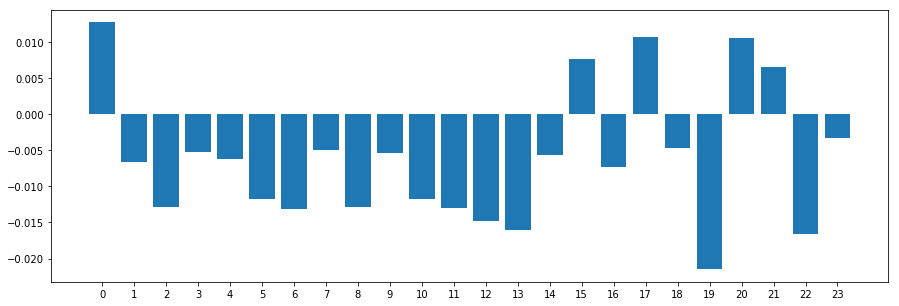

conv2d_2 



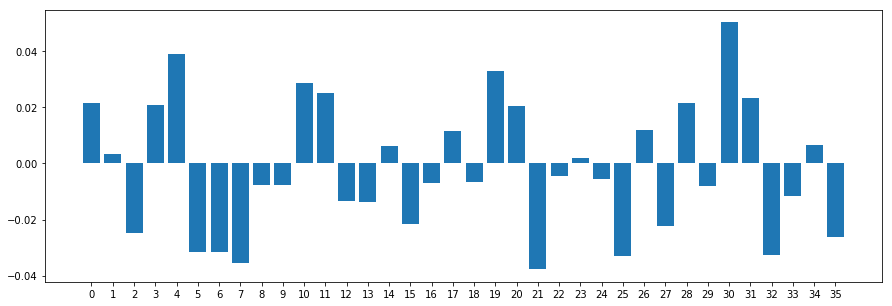

conv2d_3 



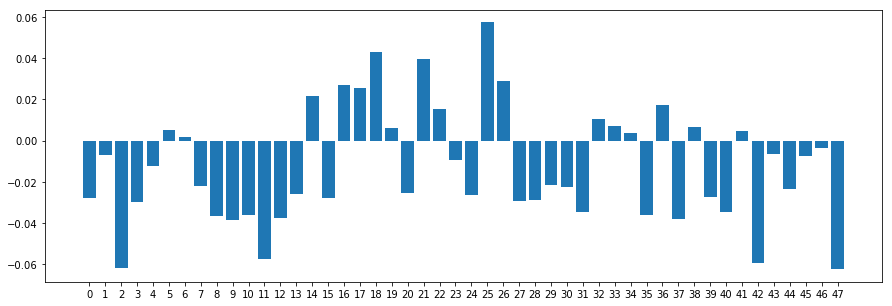

conv2d_4 



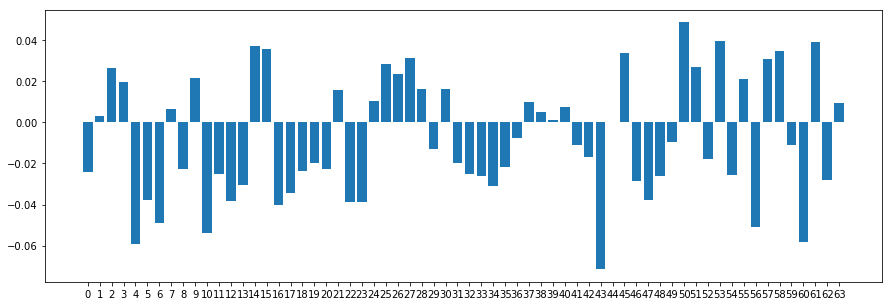

conv2d_5 



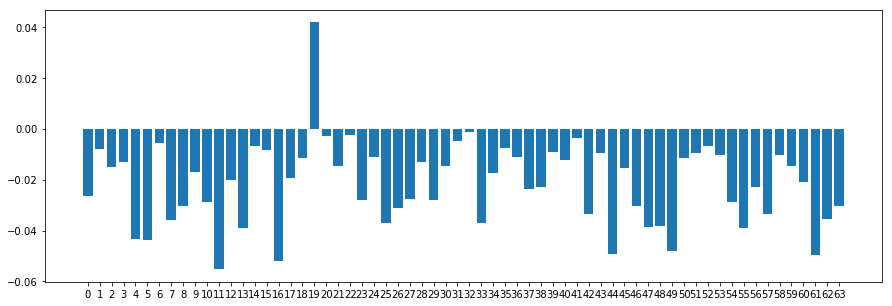

dense_1 



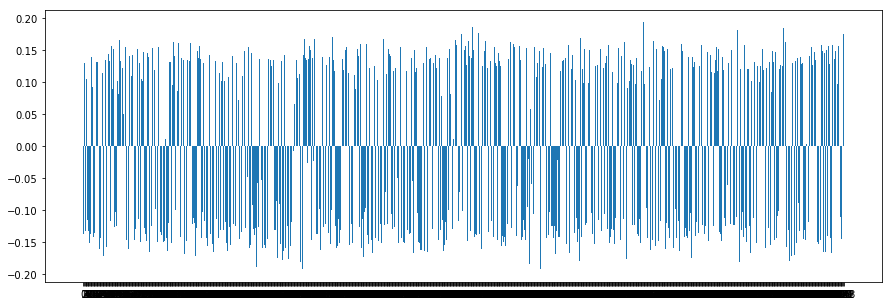

dense_2 



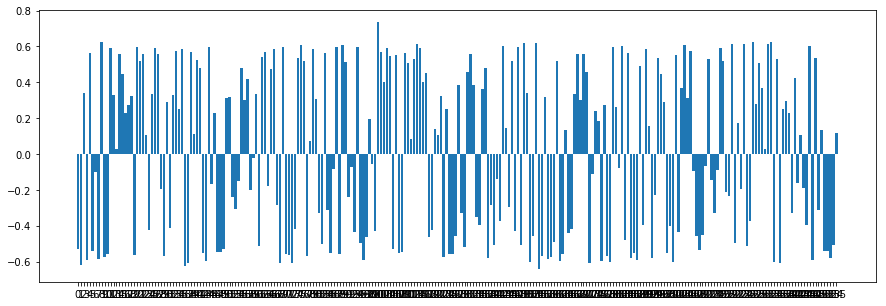

dense_3 



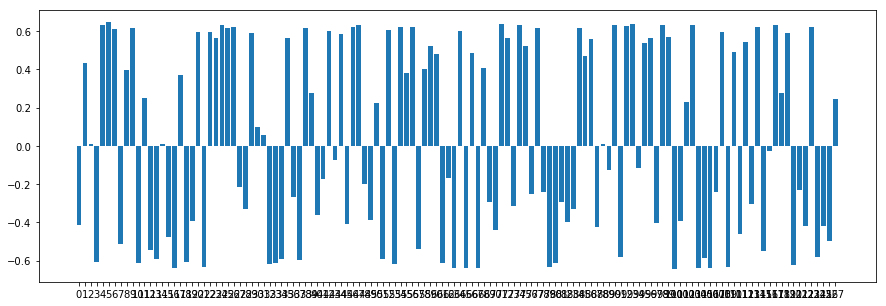

dense_4 



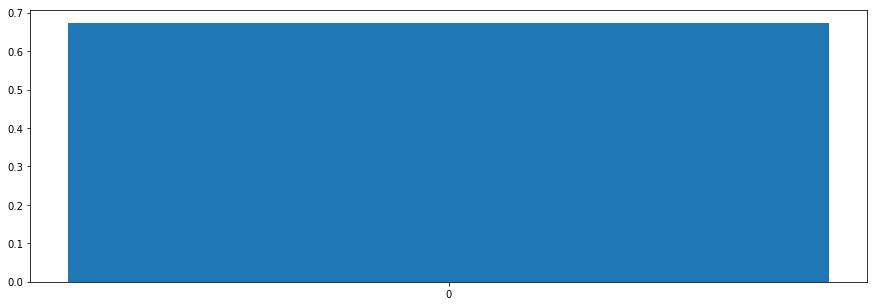

In [4]:
for layer in model.layers:
    g=layer.get_config()
    h=layer.get_weights()
    if len(h) > 0:
        print(g['name'],"\n")
        # h[0]: weights, h[1]: biases
        
        y = h[1]
        x = np.arange(len(y))
        fig, ax = plt.subplots(figsize=(15,5))
        ax.bar(x, y)
        ax.set_xticks(x)
        plt.show()

## Visualize Weights

weights: -1.27603 to 0.895754
conv2d_1
convolutional
(5, 5, 1, 24)
total: 24
conv2d_2
convolutional
(5, 5, 24, 36)
total: 864
conv2d_3
convolutional
(5, 5, 36, 48)
total: 1728
conv2d_4
convolutional
(3, 3, 48, 64)
total: 3072
conv2d_5
convolutional
(3, 3, 64, 64)
total: 4096
dense_1
fully connected
(896, 1024)
dense_2
fully connected
(1024, 256)
dense_3
fully connected
(256, 128)
dense_4
fully connected
(128, 1)


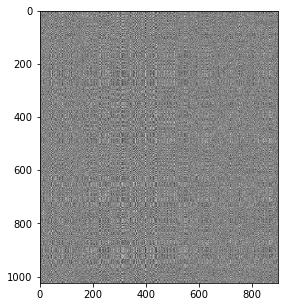

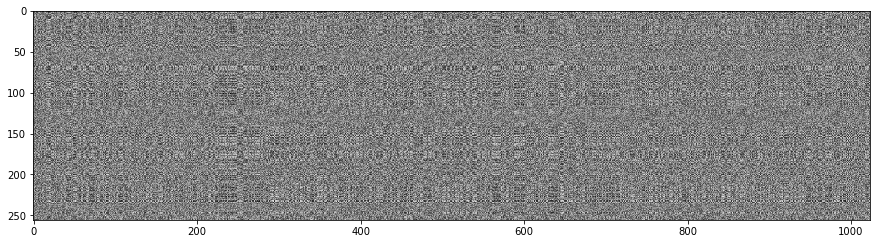

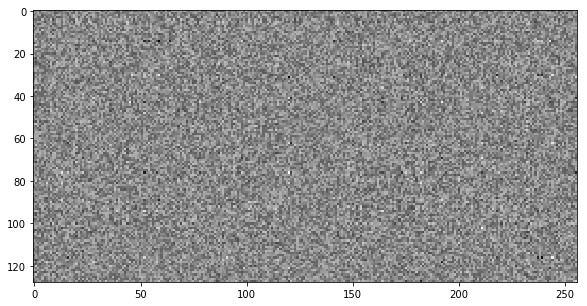

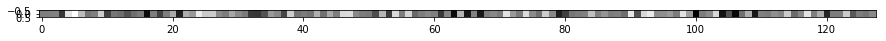

In [6]:
# Normalize the weights for visualization
min_weight = 0
max_weight = 0
for layer in model.layers:
    h=layer.get_weights()
    if len(h) > 0:
        min_w = min([x.min() for x in h])
        max_w = max([x.max() for x in h])
        if min_w < min_weight:
            min_weight = min_w
        if max_w > max_weight:
            max_weight = max_w

print("weights:", min_weight, "to", max_weight)        

def normalize(array, min_w, max_w):
    return (array-min_w)/(max_w-min_w)

for layer in model.layers:
    c=layer.get_config()
    h=layer.get_weights()
    if len(h) > 0:
        print(c['name'])
        # h[0]: weights, h[1]: biases
        if len(h[0].shape) == 4:
            print('convolutional')
            print(h[0].shape)
#             print(h[0].shape[2:4])
            print("total:", h[0].shape[2]*h[0].shape[3])
#             fig, ax = plt.subplots(*h[0].shape[2:4], figsize=(1,1))
#             for i in range(h[0].shape[2]):
#                 for j in range(h[0].shape[3]):
#                     n = normalize(h[0][:,:,i,j], min_weight, max_weight)
#                     plt.imshow(n, cmap='gray')
        elif len(h[0].shape) == 2:
            print('fully connected')
            print(h[0].shape)
            fig, ax = plt.subplots(figsize=(15,5))
            n = normalize(h[0], min_weight, max_weight).T
            plt.imshow(n, cmap='gray')
        else:
            print('others:', h[0].shape)

## Visualize Activations